In [1]:
import fsspec
from fsspec.core import url_to_fs
fs = fsspec.filesystem('s3',use_listings_cache=False,anon=True,)

ref_files = fs.glob('s3::imos-data/IMOS/ANMN/NRS/NRSMAI/Biogeochem_profiles/*SBE19plus*.nc')
ref_files[0:5]

['imos-data/IMOS/ANMN/NRS/NRSMAI/Biogeochem_profiles/IMOS_ANMN-NRS_CDEKOSTUZ_20130130T000612Z_NRSMAI_FV01_Profile-SBE19plus_C-20160524T001746Z.nc',
 'imos-data/IMOS/ANMN/NRS/NRSMAI/Biogeochem_profiles/IMOS_ANMN-NRS_CDEKOSTUZ_20170602T002825Z_NRSMAI_FV01_Profile-SBE19plus_C-20180307T024607Z.nc',
 'imos-data/IMOS/ANMN/NRS/NRSMAI/Biogeochem_profiles/IMOS_ANMN-NRS_CDEKOSTUZ_20170627T002425Z_NRSMAI_FV01_Profile-SBE19plus_C-20180307T025016Z.nc',
 'imos-data/IMOS/ANMN/NRS/NRSMAI/Biogeochem_profiles/IMOS_ANMN-NRS_CDEKOSTUZ_20170801T004358Z_NRSMAI_FV01_Profile-SBE19plus_C-20180307T021501Z.nc',
 'imos-data/IMOS/ANMN/NRS/NRSMAI/Biogeochem_profiles/IMOS_ANMN-NRS_CDEKOSTUZ_20170922T002538Z_NRSMAI_FV01_Profile-SBE19plus_C-20180307T021635Z.nc']

In [6]:
from dask.distributed import Client
client = Client(n_workers=16,threads_per_worker=16) 
client

/opt/conda/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33673 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/nickmortimer/proxy/33673/status,
Dashboard: /user/nickmortimer/proxy/33673/status,Workers: 16
Total threads: 256,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41233,Workers: 16
Dashboard: /user/nickmortimer/proxy/33673/status,Total threads: 256
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:44503,Total threads: 16
Dashboard: /user/nickmortimer/proxy/34165/status,Memory: 512.00 MiB
Nanny: tcp://127.0.0.1:33013,


In [21]:
import intake

cat =intake.open_catalog('./catalogue.yml')

In [22]:
rotto =cat.rottnest.read()

In [26]:
rotto.TIME.max()

<xarray.DataArray 'TIME' ()>
array('2021-01-21T12:00:00.000000000', dtype='datetime64[ns]')

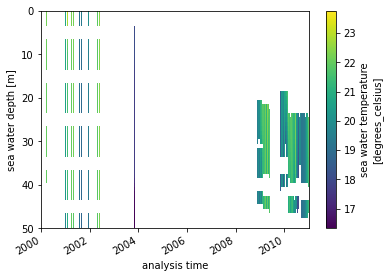

In [25]:
rotto.sel(TIME=slice("2000",'2010')).TEMP_GRID.plot(ylim=[50,0])

In [7]:
import s3fs
import xarray as xr
from dask import bag as db

def open_cdt(url):
    s3 = s3fs.S3FileSystem(anon=True,default_fill_cache=False,default_cache_type=None)
    with s3.open(url,) as f:
        data=xr.open_dataset(f,engine='h5netcdf').load().squeeze()
        data['TEMP'] = data['TEMP']#[data.TEMP_quality_control==1]
    return data


b = db.from_sequence(ref_files)
cast = db.map(open_cdt,b).compute()

In [8]:
commonvars = list(set.intersection(*list((map(lambda x:set([i for i in x.data_vars]),cast)))))
cast = [ds[commonvars] for ds in cast]

In [10]:
c =xr.concat(cast,dim='TIME')
c.isel(TIME=1).DEPTH

<xarray.DataArray 'DEPTH' (DEPTH: 211)>
array([ 0.991   ,  0.992   ,  1.984   , ..., 86.294998, 87.286003, 88.278   ])
Coordinates:
  * DEPTH      (DEPTH) float64 0.991 0.992 1.984 1.985 ... 86.29 87.29 88.28
    TIME       datetime64[ns] 2017-06-02T00:28:25.243003648
    LATITUDE   float64 -42.6
    LONGITUDE  float64 148.2
Attributes:
    axis:             Z
    standard_name:    depth
    long_name:        actual depth
    units:            m
    reference_datum:  sea surface
    positive:         down
    valid_min:        -5.0
    valid_max:        12000.0